# Align two images using lists of stars

In this example, we will deal with aligning an image of the Galactic Center, obtained with HAWK-I/VLT (*HAWKI_H_lnx_jitter_3.fits.gz*) with a larger reference image obtained with OmegaCam/VISTA ( *VVV_J_Field5.fits.gz*).

The images are very large, contain tens of thousands of stars, are from different instruments with different pixel scales (0.34" vs. 0.1"), and the HAWK-I image only covers a fraction of the VVV image. Additionally, the images are taken with different filters, which has a very strong effect in the highly extinguished Galactic Cetner environment. Take a look at the images in ds9 and see whether you could align them by eye!

We do this alignment in my group because we register our survey images (obtained with HAWK-I at the VLT) to the VVV survey images.

The lists of stars (*VVV_J_Field5_stars.txt*,*HAWKI_H_stars_3.txt*) were obtained with the IDL StarFinder package (not discussed here).

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import astroalign as aa
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline


### Read image and star list for VVV

In [2]:
#Read VVV image
img_vvv = fits.getdata('./VVV_J_Field5.fits.gz')
# The next line is needed because other wise astroalign cannot handle the image
vvv_img = pd.DataFrame(np.array(img_vvv).byteswap().newbyteorder())
xsize = vvv_img.shape[0]
ysize = vvv_img.shape[1]
xh = round(xsize/2)
yh = round(ysize/2)

#Read list of stellar positions in VVV image
print(f'Size of VVV image is {xsize} x {ysize}.')
tab_vvv = Table.read('./VVV_J_Field5_stars.txt',format='ascii')
n_vvv = len(tab_vvv)
x_vvv = tab_vvv['x']
y_vvv = tab_vvv['y']
print(f'There are {len(x_vvv)} stars in the VVV image.')

Size of VVV image is 1595 x 1595.
There are 3496 stars in the VVV image.


The long lists of stars are a problem, because astroalign runs out of iterations when searching for corresponding triangles.
However, we know where the HAWK-I image is located (approximately) on the VVV image.
We therefore limit the lists to the relevant section of the image
Alignment will fail if we do not do this, because the number of stars is just too large.

Our star lists are sorted by magnitude, so we also limit the HAWK-I star list to a number not larger than stars in the corresponding section of the VVV image.

In [3]:
idx = np.nonzero((x_vvv > xh) & (y_vvv > yh)) # limit list of stars to upper right quadrant
x_vvv = x_vvv[idx]
y_vvv = y_vvv[idx]
print(f'There are {len(x_vvv)} stars in the corresponding section of the VVV image.')
vvv_xy = np.array([[x, y] for x, y in zip(x_vvv, y_vvv)], dtype="float64")

There are 949 stars in the corresponding section of the VVV image.


Read list of stellar positions in HAWK-I image.
Limit number of stars to number in VVV image to facilitate the procedure
(too many stars will make it fail).


In [4]:
tab_img = Table.read('./HAWKI_H_stars_3.txt',format='ascii')
x_img = tab_img['x'][0:n_vvv]
y_img = tab_img['y'][0:n_vvv]
img_xy = np.array([[x, y] for x, y in zip(x_img, y_img)], dtype="float64")


### Determine transformation and obtained transformed lists of stars, image and footprint

Notice that we need to set max_control_points=200 (default is 50).
Without this change the alignemnt will fail.

In [5]:
p, (pos_img, pos_img_t) = aa.find_transform(img_xy, vvv_xy, max_control_points=200)
print("\nTranformation matrix:\n{}".format(p.params))
np.savetxt('aa_stars_hawki_chip3.txt',pos_img)
np.savetxt('aa_stars_vvv_chip3.txt',pos_img_t)

img_hawki = fits.getdata('./HAWKI_H_lnx_jitter_3.fits.gz')
img_hawki = pd.DataFrame(np.array(img_hawki).byteswap().newbyteorder())

img_aligned, footprint = aa.apply_transform(p, img_hawki, vvv_img, fill_value=0)

fits.writeto('HAWKI_aligned.fits.gz',img_aligned,overwrite=True)


Tranformation matrix:
[[ 3.12096422e-01 -8.37870997e-03  7.19385070e+02]
 [ 8.37870997e-03  3.12096422e-01  7.48634675e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Plot results

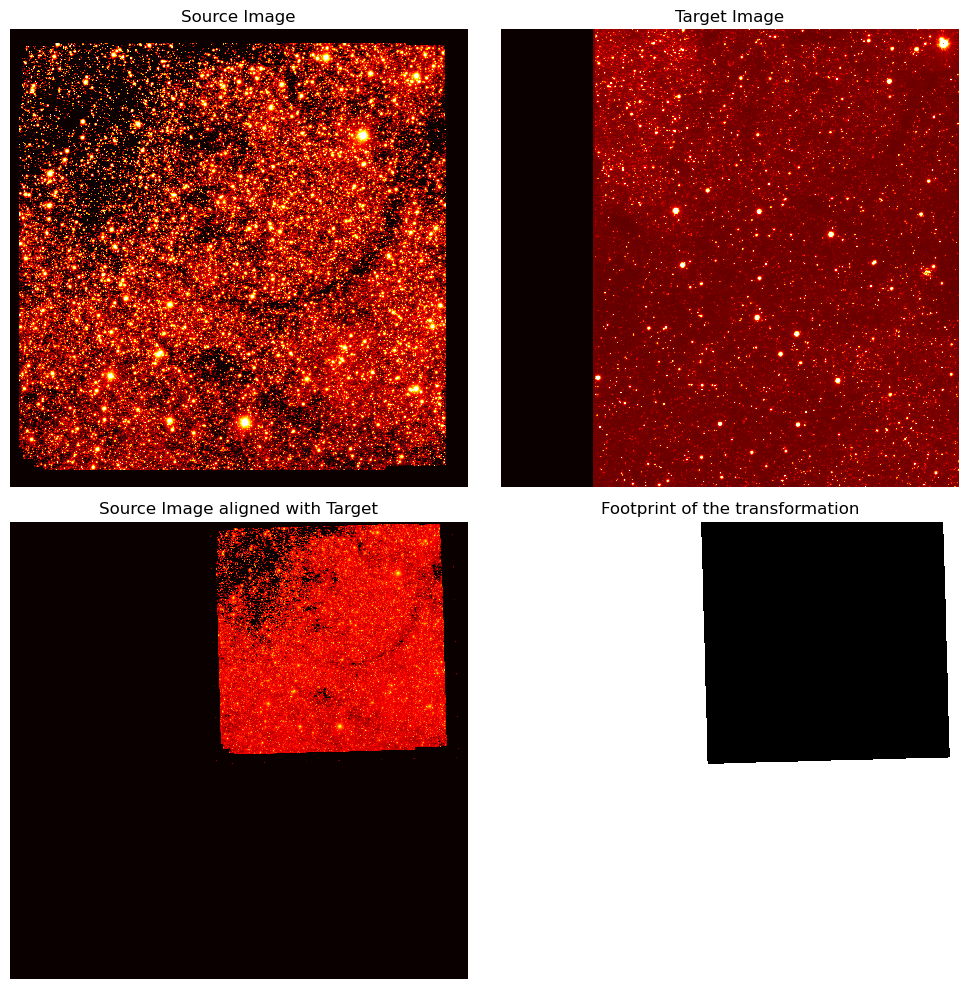

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(img_hawki, cmap='hot', interpolation='none', origin='lower', aspect='equal', norm=colors.LogNorm(vmin=.01*max(img_hawki),vmax=max(img_hawki),clip=True))
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image")

axes[0, 1].imshow(img_vvv, cmap='hot', interpolation='none', origin='lower', aspect='equal', norm=colors.LogNorm(vmin =800, vmax = 2000, clip=True))
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image")

axes[1, 0].imshow(img_aligned, cmap='hot', interpolation='none', origin='lower', aspect='equal',norm=colors.LogNorm(vmin=1,vmax=.5e6,clip=True))
axes[1, 0].axis('off')
axes[1, 0].set_title("Source Image aligned with Target")

axes[1, 1].imshow(footprint, cmap='gray', interpolation='none', aspect='equal',origin='lower')
axes[1, 1].axis('off')
axes[1, 1].set_title("Footprint of the transformation")

axes[1, 0].axis('off')

plt.tight_layout()
plt.show()